In [2]:
#! pip install segmentation-models

In [114]:
import tensorflow
import segmentation_models as sm
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt

In [157]:
SIZE_X = 256 #Resize images (height  = X, width = Y)
SIZE_Y = 256

#Capture training image info as a list
train_images = []

In [158]:
for directory_path in glob.glob("images"):
    for img_path in glob.glob(os.path.join(directory_path, "*.tif")):
        #print(img_path)
        img = cv2.imread(img_path,0)
        #img = cv2.imread(img_path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        #img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        #train_labels.append(label)
#Convert list to array for machine learning processing        
train_images = np.array(train_images)
train_images=train_images/255.

In [159]:
train_images.dtype

dtype('float64')

In [160]:
train_images=np.reshape(train_images,(165,256,256,1))

In [161]:
train_masks = [] 
for directory_path in glob.glob("mask"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.tif")):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
        #mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)
        train_masks.append(mask)
        #train_labels.append(label)
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)
train_masks=train_masks/255.

In [162]:
train_masks.dtype

dtype('float64')

In [163]:
train_masks=np.reshape(train_masks,(165,256,256,1))
train_masks.shape

(165, 256, 256, 1)

In [164]:
X = train_images
Y = train_masks

In [165]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [166]:
x_train.shape

(132, 256, 256, 1)

In [167]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tensorflow.reduce_sum(y_true * y_pred)
    denominator = tensorflow.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tensorflow.keras.backend.epsilon())

def loss(y_true, y_pred):
    return tensorflow.keras.backend.binary_crossentropy(y_true, y_pred) - tensorflow.math.log(dice_coefficient(y_true, y_pred) + tensorflow.keras.backend.epsilon())

In [168]:
BACKBONE = 'resnet34'
preprocess_input = get_preprocessing(BACKBONE)

In [169]:
#from tensorflow.keras.utils import generic_utils
from segmentation_models import Unet
#model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model = Unet(backbone_name='resnet34', encoder_weights=None, input_shape=(None, None, 1))

In [153]:
#print(model.summary())

In [170]:
model.compile(optimizer='Adam', loss=loss, metrics=[dice_coefficient])

In [171]:
from segmentation_models import get_preprocessing

X_train = preprocess_input(x_train)
X_val = preprocess_input(x_val)

In [172]:
model.fit(
    x=X_train,
    y=y_train,
    batch_size=16,   
    epochs=10,
    validation_data=(X_val, y_val)
    )

Train on 132 samples, validate on 33 samples
Epoch 1/10
132/132 [==============================] - 151s 1s/sample - loss: 2.7956 - dice_coefficient: 0.1564 - val_loss: 4745108.0152 - val_dice_coefficient: 0.1136
Epoch 2/10
128/132 [============================>.] - ETA: 4s - loss: 2.0934 - dice_coefficient: 0.2134 

KeyboardInterrupt: 

In [94]:
test=x_val[0,:,:,:]
test1=np.reshape(test,(1,128,128,1))
test1.shape

(1, 128, 128, 1)

In [105]:
#test_img = cv2.imread('/0.png', cv2.IMREAD_COLOR)       
#test_img = cv2.resize(test_img, (SIZE_Y, SIZE_X))
#test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
#test_img = np.expand_dims(test_img, axis=0)

prediction = model.predict(test1)
prediction_t = (prediction > 0.5).astype(np.uint8)

In [108]:
prediction_t.shape

(1, 128, 128, 1)

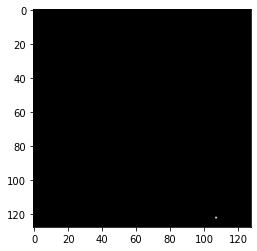

In [110]:
prediction_image = prediction_t.reshape(128,128)
#pred_img=prediction_image.round()
plt.imshow(prediction_image, cmap='gray')

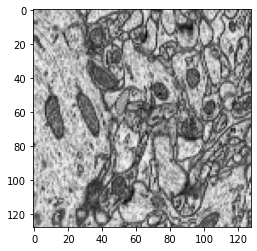

In [102]:
plt.imshow(test1.reshape(128,128), cmap='gray')